In [19]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels
batch_size = 256
g_dim = 100

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [21]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')
def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

In [22]:
class layer:
    def __init__(self, in_size, out_size):
        self.W = tf.Variable(tf.random_normal([in_size, out_size], mean=0.0, stddev=0.1))
        self.b = tf.Variable(tf.random_normal([1, out_size], mean=0.0, stddev=0.1))
    def output(self, inputs, activation_function=None):
        if activation_function == None:
            return tf.matmul(inputs, self.W) + self.b
        else :
            return activation_function(tf.matmul(inputs, self.W) + self.b)

def weight_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

In [23]:
layer_e = layer(4*4*64, g_dim)
layer_d = layer(g_dim, 4*4*64)
layer_g = layer(g_dim, 4*4*64)

encoder_var = {
    "W_e_conv1" : weight_variable([3,3, 1,16]),
    "W_e_conv2" : weight_variable([3,3,16,32]),
    "W_e_conv3" : weight_variable([3,3,32,64]),
    "b_e_conv1" : bias_variable([16]),   
    "b_e_conv2" : bias_variable([32]),
    "b_e_conv3" : bias_variable([64])
}

decoder_var = {
    "W_d_conv1" : weight_variable([3,3,32,64]),
    "W_d_conv2" : weight_variable([3,3,16,32]),
    "W_d_conv3" : weight_variable([3,3, 1,16]),
    "b_d_conv1" : bias_variable([32]),
    "b_d_conv2" : bias_variable([16]),
    "b_d_conv3" : bias_variable([1])
}

generator_var = {
    "W_d_conv1" : weight_variable([3,3,32,64]),
    "W_d_conv2" : weight_variable([3,3,16,32]),
    "W_d_conv3" : weight_variable([3,3, 1,16]),
    "b_d_conv1" : bias_variable([32]),
    "b_d_conv2" : bias_variable([16]),
    "b_d_conv3" : bias_variable([1])
}

var_d = [encoder_var[e] for e in encoder_var]+[decoder_var[d] for d in decoder_var]+[layer_e.W, layer_e.b, layer_d.W, layer_d.b]
var_g = [generator_var[g] for g in generator_var]+[layer_g.W, layer_g.b]


In [24]:
def encoder(x):
    x_origin = tf.reshape(x, [-1,28,28,1])      #28x28x1
    h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, encoder_var["W_e_conv1"]), encoder_var["b_e_conv1"]))     #14x14x16
    h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, encoder_var["W_e_conv2"]), encoder_var["b_e_conv2"]))    #7x7x32
    h_e_conv3 = tf.nn.relu(tf.add(conv2d(h_e_conv2, encoder_var["W_e_conv3"]), encoder_var["b_e_conv3"]))    #4x4x64
    h_e_conv3_reshape = tf.reshape(h_e_conv3, [-1,4*4*64])
    h_e_layer = layer_e.output(h_e_conv3_reshape, tf.nn.relu)
#     h_e_layer = layer_e.output(h_e_conv3_reshape, tf.nn.sigmoid)
    return h_e_layer
    
def decoder(z):
    h_d_layer = layer_d.output(z, tf.nn.relu)
#     h_d_layer = layer_d.output(z, tf.nn.sigmoid)
    h_d_layer_reshape = tf.reshape(h_d_layer, [-1,4,4,64])
    
    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 7, 7, 32])
    h_d_conv1 = tf.nn.relu(deconv2d(h_d_layer_reshape, decoder_var["W_d_conv1"], output_shape_d_conv1)+decoder_var["b_d_conv1"])

    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 14, 14, 16])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, decoder_var["W_d_conv2"], output_shape_d_conv1)+decoder_var["b_d_conv2"])

    output_shape_d_conv2 = tf.stack([tf.shape(z)[0], 28, 28, 1])
    h_d_conv3 = tf.nn.relu(deconv2d(h_d_conv2, decoder_var["W_d_conv3"], output_shape_d_conv2)+decoder_var["b_d_conv3"])
    return h_d_conv3

def generator(z):
    h_d_layer = layer_g.output(z, tf.nn.relu)
#     h_d_layer = layer_d.output(z, tf.nn.sigmoid)
    h_d_layer_reshape = tf.reshape(h_d_layer, [-1,4,4,64])
    
    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 7, 7, 32])
    h_d_conv1 = tf.nn.relu(deconv2d(h_d_layer_reshape, generator_var["W_d_conv1"], output_shape_d_conv1)+generator_var["b_d_conv1"])

    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 14, 14, 16])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, generator_var["W_d_conv2"], output_shape_d_conv1)+generator_var["b_d_conv2"])

    output_shape_d_conv2 = tf.stack([tf.shape(z)[0], 28, 28, 1])
    h_d_conv3 = tf.nn.relu(deconv2d(h_d_conv2, generator_var["W_d_conv3"], output_shape_d_conv2)+generator_var["b_d_conv3"])
    return h_d_conv3

def discriminator(x):
    return decoder(encoder(x))

In [25]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def loss(x):
#     return tf.reduce_mean(tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2))
    return tf.reduce_mean(tf.abs(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784])))
#     return tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2)

In [26]:
x_d = tf.placeholder(tf.float32, shape = [None, 784])
x_g = tf.placeholder(tf.float32, shape = [None, g_dim])

gamma = 0.5
# k_t = 0.
k_t = tf.Variable(0.0, tf.float32)

# d_loss = loss(x_d)-k_t*loss(generator(x_g))
# d_loss = loss(x_d)
d_loss = tf.reduce_mean(loss(x_d)-k_t*loss(generator(x_g)))
# g_loss = loss(generator(x_g))
g_loss = tf.reduce_mean(loss(generator(x_g)))

g_sample = generator(x_g)

M_global = loss(x_d) + tf.abs(gamma*loss(x_d) - loss(generator(x_g)))

d_optimizer = tf.train.AdamOptimizer(0.00001).minimize(d_loss, var_list= var_d)
g_optimizer = tf.train.AdamOptimizer(0.00001).minimize(g_loss, var_list= var_g)

# balancer = gamma*loss(x_d) - loss(generator(x_g))
balancer = tf.reduce_mean(gamma*loss(x_d) - loss(generator(x_g)))
# update_k = k_t.assign(k_t + 0.001 * balancer)
update_k = tf.assign(k_t, tf.clip_by_value(k_t + 0.001 * balancer, 0, 1))
# tf.clip_by_value(self.k_t + self.lambda_k * self.balance, 0, 1)



In [27]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

step: 0  d-loss: 0.13814  g-loss: 0.0165961 k_t: 5.21346e-05 M_global: 0.190616
step: 1000  d-loss: 0.128975  g-loss: 0.0128923 k_t: 0.0594824 M_global: 0.18172
step: 2000  d-loss: 0.12127  g-loss: 0.0324558 k_t: 0.0996548 M_global: 0.1543
step: 3000  d-loss: 0.103622  g-loss: 0.108275 k_t: 0.0877488 M_global: 0.164837
step: 4000  d-loss: 0.102879  g-loss: 0.0946781 k_t: 0.0345127 M_global: 0.147751
step: 5000  d-loss: 0.0990281  g-loss: 0.0603969 k_t: 0.012146 M_global: 0.110278
step: 6000  d-loss: 0.0978382  g-loss: 0.0479486 k_t: 0.00697664 M_global: 0.0993105
step: 7000  d-loss: 0.0911234  g-loss: 0.0403898 k_t: 0.013137 M_global: 0.0970913
step: 8000  d-loss: 0.0934109  g-loss: 0.0510606 k_t: 0.00833031 M_global: 0.0979788
step: 9000  d-loss: 0.0949561  g-loss: 0.0461363 k_t: 0.0091009 M_global: 0.0969277
step: 10000  d-loss: 0.0903684  g-loss: 0.052445 k_t: 0.00456248 M_global: 0.0977489


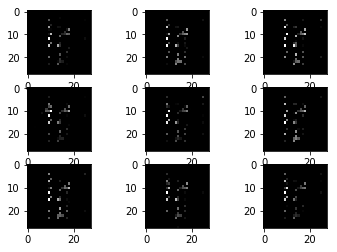

In [31]:
# zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [32]:
for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0910859  g-loss: 0.0525855 k_t: 0.00455554 M_global: 0.0982483
step: 1000  d-loss: 0.0925112  g-loss: 0.0432432 k_t: 0.00203779 M_global: 0.0956558
step: 2000  d-loss: 0.0888409  g-loss: 0.0454328 k_t: 0.00399826 M_global: 0.0899441
step: 3000  d-loss: 0.092186  g-loss: 0.0462009 k_t: 0.00253441 M_global: 0.0923524
step: 4000  d-loss: 0.0890407  g-loss: 0.0505442 k_t: 0.00832695 M_global: 0.0952749
step: 5000  d-loss: 0.0857218  g-loss: 0.0424908 k_t: 0.000267211 M_global: 0.0861089
step: 6000  d-loss: 0.086632  g-loss: 0.0437404 k_t: 0.00159074 M_global: 0.0870912
step: 7000  d-loss: 0.0872474  g-loss: 0.0448726 k_t: 0.00331535 M_global: 0.0885706
step: 8000  d-loss: 0.0908583  g-loss: 0.0481241 k_t: 0.00582185 M_global: 0.0936933
step: 9000  d-loss: 0.0844391  g-loss: 0.04277 k_t: 0.0015315 M_global: 0.0850223
step: 10000  d-loss: 0.0869261  g-loss: 0.0447336 k_t: 0.0021297 M_global: 0.0882443


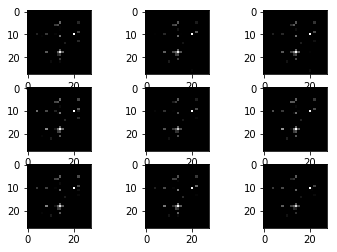

In [36]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [22]:
for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0507546  g-loss: 0.023656 k_t: 0.0461516 M_global: 0.0541136
step: 1000  d-loss: 0.0471655  g-loss: 0.0235202 k_t: 0.0467315 M_global: 0.0488767
step: 2000  d-loss: 0.0457362  g-loss: 0.0234209 k_t: 0.0473112 M_global: 0.0468455
step: 3000  d-loss: 0.0470849  g-loss: 0.023409 k_t: 0.0479626 M_global: 0.0489024
step: 4000  d-loss: 0.0473888  g-loss: 0.0228861 k_t: 0.0487873 M_global: 0.0498719
step: 5000  d-loss: 0.0463009  g-loss: 0.0227528 k_t: 0.0499098 M_global: 0.048402
step: 6000  d-loss: 0.0459907  g-loss: 0.0220586 k_t: 0.0510488 M_global: 0.0486166
step: 7000  d-loss: 0.0445357  g-loss: 0.0217438 k_t: 0.0521452 M_global: 0.0467606
step: 8000  d-loss: 0.0444641  g-loss: 0.0217497 k_t: 0.0531464 M_global: 0.0466803
step: 9000  d-loss: 0.0449894  g-loss: 0.0222211 k_t: 0.0540908 M_global: 0.0470659
step: 10000  d-loss: 0.0429596  g-loss: 0.0217715 k_t: 0.0550158 M_global: 0.0444646


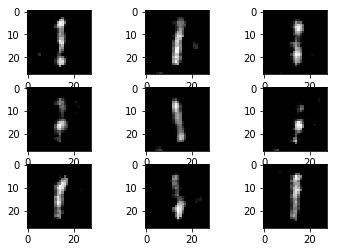

In [23]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [24]:
for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0429454  g-loss: 0.0215675 k_t: 0.0550159 M_global: 0.0446304
step: 1000  d-loss: 0.0443127  g-loss: 0.0215943 k_t: 0.0558566 M_global: 0.0466839
step: 2000  d-loss: 0.0443735  g-loss: 0.021824 k_t: 0.0566229 M_global: 0.0465899
step: 3000  d-loss: 0.0429038  g-loss: 0.0219562 k_t: 0.0572818 M_global: 0.044286
step: 4000  d-loss: 0.042058  g-loss: 0.021586 k_t: 0.0578705 M_global: 0.0433748
step: 5000  d-loss: 0.0429612  g-loss: 0.0219599 k_t: 0.0583521 M_global: 0.044404
step: 6000  d-loss: 0.0423397  g-loss: 0.0221759 k_t: 0.0587459 M_global: 0.0439971
step: 7000  d-loss: 0.0430254  g-loss: 0.0219721 k_t: 0.0590889 M_global: 0.0445135
step: 8000  d-loss: 0.0413209  g-loss: 0.0210602 k_t: 0.0593709 M_global: 0.0427967
step: 9000  d-loss: 0.0419871  g-loss: 0.0219238 k_t: 0.0595901 M_global: 0.0435706
step: 10000  d-loss: 0.0422414  g-loss: 0.0208271 k_t: 0.0597809 M_global: 0.0444025


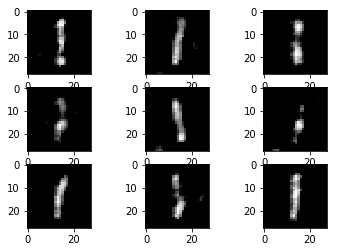

In [25]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [26]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0419477  g-loss: 0.0213801 k_t: 0.0597815 M_global: 0.0434586
step: 1000  d-loss: 0.0408291  g-loss: 0.0212278 k_t: 0.0599528 M_global: 0.0422787
step: 2000  d-loss: 0.0421081  g-loss: 0.0210883 k_t: 0.0601166 M_global: 0.0439754
step: 3000  d-loss: 0.0415205  g-loss: 0.0208901 k_t: 0.0602344 M_global: 0.0432782
step: 4000  d-loss: 0.04048  g-loss: 0.0209695 k_t: 0.0603256 M_global: 0.041842
step: 5000  d-loss: 0.0411147  g-loss: 0.0211593 k_t: 0.0603999 M_global: 0.0424298
step: 6000  d-loss: 0.0418776  g-loss: 0.0207641 k_t: 0.0604206 M_global: 0.0439341
step: 7000  d-loss: 0.0393454  g-loss: 0.0210414 k_t: 0.0604302 M_global: 0.0413498
step: 8000  d-loss: 0.0398943  g-loss: 0.0203162 k_t: 0.0604251 M_global: 0.0413667
step: 9000  d-loss: 0.0413921  g-loss: 0.021095 k_t: 0.0603752 M_global: 0.0429036
step: 10000  d-loss: 0.0415344  g-loss: 0.0208305 k_t: 0.060274 M_global: 0.0433544
step: 11000  d-loss: 0.0403142  g-loss: 0.0205832 k_t: 0.0600822 M_global: 0.041743

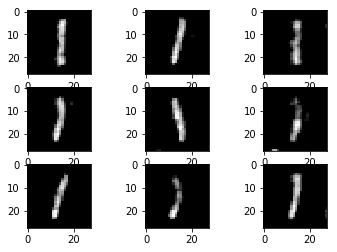

In [27]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [28]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0365903  g-loss: 0.0177989 k_t: 0.0676553 M_global: 0.0388929
step: 1000  d-loss: 0.0354999  g-loss: 0.0185346 k_t: 0.0679368 M_global: 0.0369142
step: 2000  d-loss: 0.0363987  g-loss: 0.0177708 k_t: 0.0682389 M_global: 0.0386462
step: 3000  d-loss: 0.0352663  g-loss: 0.0183553 k_t: 0.0685713 M_global: 0.0366178
step: 4000  d-loss: 0.0367077  g-loss: 0.0178614 k_t: 0.0689275 M_global: 0.0390468
step: 5000  d-loss: 0.0357456  g-loss: 0.0177504 k_t: 0.0693139 M_global: 0.0377135
step: 6000  d-loss: 0.0347282  g-loss: 0.0176971 k_t: 0.0696975 M_global: 0.0362453
step: 7000  d-loss: 0.0349011  g-loss: 0.0180961 k_t: 0.0701025 M_global: 0.0361809
step: 8000  d-loss: 0.0359506  g-loss: 0.0177036 k_t: 0.0704695 M_global: 0.0380937
step: 9000  d-loss: 0.0351477  g-loss: 0.0182776 k_t: 0.0708142 M_global: 0.0364986
step: 10000  d-loss: 0.0363142  g-loss: 0.0177883 k_t: 0.0711566 M_global: 0.0385816
step: 11000  d-loss: 0.0347349  g-loss: 0.0181445 k_t: 0.0714399 M_global: 0.0

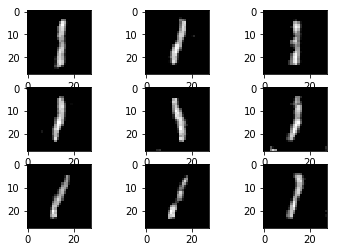

In [29]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [30]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0335229  g-loss: 0.0173816 k_t: 0.0769159 M_global: 0.0349082
step: 1000  d-loss: 0.0331007  g-loss: 0.0167656 k_t: 0.0770265 M_global: 0.0348225
step: 2000  d-loss: 0.0329962  g-loss: 0.0169634 k_t: 0.0771322 M_global: 0.0344935
step: 3000  d-loss: 0.0339379  g-loss: 0.0174793 k_t: 0.0772279 M_global: 0.0354524
step: 4000  d-loss: 0.032591  g-loss: 0.0171546 k_t: 0.0772742 M_global: 0.0341129
step: 5000  d-loss: 0.0318654  g-loss: 0.017427 k_t: 0.0773098 M_global: 0.0340333
step: 6000  d-loss: 0.0343606  g-loss: 0.0169322 k_t: 0.0773495 M_global: 0.0365732
step: 7000  d-loss: 0.0333369  g-loss: 0.016951 k_t: 0.0773504 M_global: 0.0350212
step: 8000  d-loss: 0.0322722  g-loss: 0.0172425 k_t: 0.077345 M_global: 0.0340454
step: 9000  d-loss: 0.034358  g-loss: 0.0171107 k_t: 0.0773293 M_global: 0.036411
step: 10000  d-loss: 0.0335352  g-loss: 0.0173735 k_t: 0.077301 M_global: 0.0349437
step: 11000  d-loss: 0.0314661  g-loss: 0.0168503 k_t: 0.0772433 M_global: 0.0332342


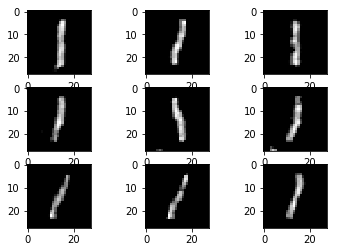

In [35]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [36]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0313479  g-loss: 0.0164356 k_t: 0.0749729 M_global: 0.0327257
step: 1000  d-loss: 0.0312832  g-loss: 0.0169356 k_t: 0.0749738 M_global: 0.0332121
step: 2000  d-loss: 0.0320246  g-loss: 0.0161842 k_t: 0.0749702 M_global: 0.0336726
step: 3000  d-loss: 0.0319954  g-loss: 0.0164385 k_t: 0.0749566 M_global: 0.0334029
step: 4000  d-loss: 0.0299797  g-loss: 0.0165709 k_t: 0.0749766 M_global: 0.0321819
step: 5000  d-loss: 0.0322626  g-loss: 0.0167049 k_t: 0.0749797 M_global: 0.0335678
step: 6000  d-loss: 0.031619  g-loss: 0.0161312 k_t: 0.075 M_global: 0.0331121
step: 7000  d-loss: 0.0316163  g-loss: 0.016221 k_t: 0.0750552 M_global: 0.0330296
step: 8000  d-loss: 0.0319319  g-loss: 0.0164224 k_t: 0.0751143 M_global: 0.0333258
step: 9000  d-loss: 0.03079  g-loss: 0.0160931 k_t: 0.0751474 M_global: 0.0320928
step: 10000  d-loss: 0.0316821  g-loss: 0.0161411 k_t: 0.0752023 M_global: 0.0332029
step: 11000  d-loss: 0.0317341  g-loss: 0.0165513 k_t: 0.075301 M_global: 0.0330415
st

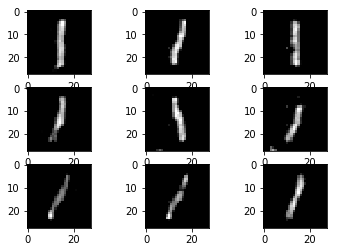

In [37]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [206]:
for step in range(100001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0307634  g-loss: 0.0168936 k_t: 0.00964507 M_global: 0.0323568
step: 1000  d-loss: 0.0315141  g-loss: 0.0217758 k_t: 0.00785393 M_global: 0.0376183
step: 2000  d-loss: 0.0321538  g-loss: 0.0140907 k_t: 0.00615741 M_global: 0.0342701
step: 3000  d-loss: 0.0317924  g-loss: 0.0173982 k_t: 0.00678315 M_global: 0.0333534
step: 4000  d-loss: 0.0315408  g-loss: 0.0101243 k_t: 0.00806059 M_global: 0.0373092
step: 5000  d-loss: 0.0310727  g-loss: 0.0117967 k_t: 0.0125216 M_global: 0.0350339
step: 6000  d-loss: 0.0313728  g-loss: 0.0288112 k_t: 0.01244 M_global: 0.0446768
step: 7000  d-loss: 0.0314398  g-loss: 0.0129572 k_t: 0.00968117 M_global: 0.0343907
step: 8000  d-loss: 0.0320332  g-loss: 0.0161761 k_t: 0.010428 M_global: 0.032277
step: 9000  d-loss: 0.0323819  g-loss: 0.0118645 k_t: 0.0117357 M_global: 0.0369171
step: 10000  d-loss: 0.0312243  g-loss: 0.0155916 k_t: 0.0151511 M_global: 0.0315993
step: 11000  d-loss: 0.0314078  g-loss: 0.0160842 k_t: 0.0123776 M_global: 0

step: 96000  d-loss: 0.0297082  g-loss: 0.0363576 k_t: 0.00100751 M_global: 0.05123
step: 97000  d-loss: 0.0295528  g-loss: 0.0376114 k_t: 0.000454865 M_global: 0.0523964
step: 98000  d-loss: 0.0302055  g-loss: 1.40374e-05 k_t: 0.00086221 M_global: 0.0452943
step: 99000  d-loss: 0.029992  g-loss: 0.0 k_t: 0.00144157 M_global: 0.044988
step: 100000  d-loss: 0.0305125  g-loss: 8.62144e-07 k_t: -0.000211251 M_global: 0.0457679


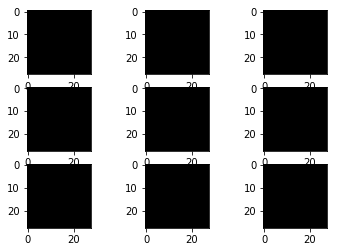

In [207]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [208]:
for step in range(100001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0302666  g-loss: 3.32747e-05 k_t: -0.000196151 M_global: 0.0453666
step: 1000  d-loss: 0.030076  g-loss: 0.0 k_t: -0.000212417 M_global: 0.0451141
step: 2000  d-loss: 0.0304685  g-loss: 0.0357063 k_t: -0.000165151 M_global: 0.0509376
step: 3000  d-loss: 0.0288192  g-loss: 0.0137574 k_t: 0.00130985 M_global: 0.0294984
step: 4000  d-loss: 0.028956  g-loss: 0.0371196 k_t: 0.000855876 M_global: 0.0516135
step: 5000  d-loss: 0.0296152  g-loss: 0.0 k_t: 0.0017007 M_global: 0.0444228
step: 6000  d-loss: 0.0291948  g-loss: 0.0188446 k_t: -0.00104597 M_global: 0.0334322
step: 7000  d-loss: 0.0294825  g-loss: 0.0102495 k_t: -0.00103003 M_global: 0.0339584
step: 8000  d-loss: 0.0293925  g-loss: 0.032814 k_t: -0.000347795 M_global: 0.0475046
step: 9000  d-loss: 0.0315898  g-loss: 3.93555e-05 k_t: 0.00210848 M_global: 0.0473454
step: 10000  d-loss: 0.0290327  g-loss: 0.0359668 k_t: -0.000188326 M_global: 0.0504798
step: 11000  d-loss: 0.0303848  g-loss: 0.0363901 k_t: 0.00067783 

step: 97000  d-loss: 0.027872  g-loss: 0.0 k_t: -0.0010185 M_global: 0.041808
step: 98000  d-loss: 0.0278294  g-loss: 0.0 k_t: -0.00053671 M_global: 0.0417441
step: 99000  d-loss: 0.0276932  g-loss: 0.0 k_t: -0.00148112 M_global: 0.0415398
step: 100000  d-loss: 0.0272787  g-loss: 0.0374983 k_t: -0.000812262 M_global: 0.0511224


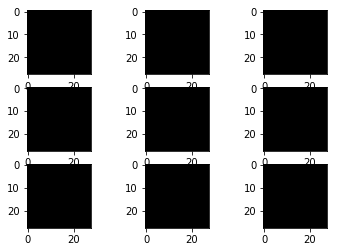

In [209]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [210]:
for step in range(100001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.028183  g-loss: 0.0370366 k_t: -0.000835222 M_global: 0.0511126
step: 1000  d-loss: 0.027264  g-loss: 0.025989 k_t: -0.00173008 M_global: 0.0395985
step: 2000  d-loss: 0.0287475  g-loss: 0.0 k_t: -0.00147514 M_global: 0.0431212
step: 3000  d-loss: 0.0281996  g-loss: 0.0297466 k_t: 0.000601366 M_global: 0.0438554
step: 4000  d-loss: 0.0269658  g-loss: 0.0271674 k_t: -0.001614 M_global: 0.0406284
step: 5000  d-loss: 0.027706  g-loss: 0.0389232 k_t: -7.57431e-06 M_global: 0.052776
step: 6000  d-loss: 0.0285723  g-loss: 0.031883 k_t: 0.00182798 M_global: 0.0461983
step: 7000  d-loss: 0.0284994  g-loss: 0.041886 k_t: 0.000421054 M_global: 0.0561445
step: 8000  d-loss: 0.0275893  g-loss: 0.000112811 k_t: 0.00226066 M_global: 0.0412716
step: 9000  d-loss: 0.0272828  g-loss: 5.38603e-05 k_t: 0.00107521 M_global: 0.0408705
step: 10000  d-loss: 0.0273722  g-loss: 0.00750861 k_t: 0.00199594 M_global: 0.0335722
step: 11000  d-loss: 0.0283885  g-loss: 0.0408211 k_t: 0.000131002 M

step: 98000  d-loss: 0.0264299  g-loss: 0.0 k_t: -0.0013582 M_global: 0.0396449
step: 99000  d-loss: 0.026554  g-loss: 0.0 k_t: 0.000287094 M_global: 0.0398309
step: 100000  d-loss: 0.0270775  g-loss: 0.0376752 k_t: -0.000146524 M_global: 0.0512111


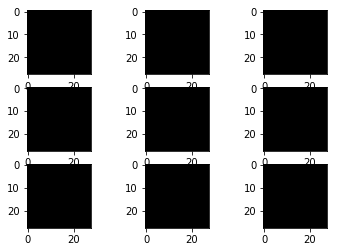

In [211]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [212]:
for step in range(500001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0258801  g-loss: 0.0374464 k_t: -0.000171034 M_global: 0.0503832
step: 1000  d-loss: 0.0282302  g-loss: 0.0352172 k_t: -0.000562854 M_global: 0.0493224
step: 2000  d-loss: 0.0277262  g-loss: 0.0020884 k_t: -0.00203683 M_global: 0.0394945
step: 3000  d-loss: 0.0270318  g-loss: 0.0 k_t: 9.04852e-05 M_global: 0.0405476
step: 4000  d-loss: 0.0269525  g-loss: 0.0380462 k_t: 0.00336595 M_global: 0.0515864
step: 5000  d-loss: 0.0264395  g-loss: 0.00576342 k_t: -0.00211548 M_global: 0.0338775
step: 6000  d-loss: 0.026651  g-loss: 0.0380733 k_t: 0.00235965 M_global: 0.0514437
step: 7000  d-loss: 0.0255438  g-loss: 0.0 k_t: -0.00163333 M_global: 0.0383157
step: 8000  d-loss: 0.0267887  g-loss: 0.0354036 k_t: -0.000486698 M_global: 0.0487894
step: 9000  d-loss: 0.0273751  g-loss: 0.0 k_t: -2.15252e-07 M_global: 0.0410627
step: 10000  d-loss: 0.0271008  g-loss: 0.0358643 k_t: -8.67419e-05 M_global: 0.0494131
step: 11000  d-loss: 0.0269081  g-loss: 0.0 k_t: -0.000195642 M_global:

step: 98000  d-loss: 0.0252193  g-loss: 0.0 k_t: 0.00170456 M_global: 0.037829
step: 99000  d-loss: 0.0258061  g-loss: 0.0 k_t: 0.00664153 M_global: 0.0387092
step: 100000  d-loss: 0.0251709  g-loss: 0.0147255 k_t: -0.000816379 M_global: 0.0273049
step: 101000  d-loss: 0.0257428  g-loss: 0.0 k_t: 0.000464094 M_global: 0.0386142
step: 102000  d-loss: 0.0262567  g-loss: 0.0340682 k_t: -0.00121097 M_global: 0.0471759
step: 103000  d-loss: 0.0252156  g-loss: 0.0 k_t: 0.000174358 M_global: 0.0378234
step: 104000  d-loss: 0.0258181  g-loss: 0.0 k_t: 0.00201069 M_global: 0.0387272
step: 105000  d-loss: 0.0250906  g-loss: 0.019579 k_t: -0.00173984 M_global: 0.0321073
step: 106000  d-loss: 0.0249663  g-loss: 0.0 k_t: 0.00294439 M_global: 0.0374494
step: 107000  d-loss: 0.0253533  g-loss: 0.0 k_t: -0.000267042 M_global: 0.0380299
step: 108000  d-loss: 0.0248422  g-loss: 0.00165639 k_t: 0.000812038 M_global: 0.0356089
step: 109000  d-loss: 0.0253029  g-loss: 0.0 k_t: 0.00298766 M_global: 0.037954

step: 195000  d-loss: 0.0205662  g-loss: 0.0 k_t: -0.00190451 M_global: 0.0308493
step: 196000  d-loss: 0.0215916  g-loss: 0.0241414 k_t: -0.000248342 M_global: 0.0349342
step: 197000  d-loss: 0.0207277  g-loss: 0.0 k_t: 0.0011832 M_global: 0.0310916
step: 198000  d-loss: 0.0206551  g-loss: 0.0 k_t: 8.5749e-05 M_global: 0.0309826
step: 199000  d-loss: 0.0202243  g-loss: 0.0 k_t: 0.000780477 M_global: 0.0303364
step: 200000  d-loss: 0.0206251  g-loss: 0.0344209 k_t: 0.00112329 M_global: 0.0447528
step: 201000  d-loss: 0.0201983  g-loss: 0.0 k_t: 0.00616908 M_global: 0.0302974
step: 202000  d-loss: 0.0211724  g-loss: 0.0 k_t: 0.0164115 M_global: 0.0317585
step: 203000  d-loss: 0.0209591  g-loss: 0.0 k_t: 0.0266533 M_global: 0.0314387
step: 204000  d-loss: 0.0192891  g-loss: 0.0 k_t: 0.0368801 M_global: 0.0289336
step: 205000  d-loss: 0.0189261  g-loss: 0.0586956 k_t: 0.018523 M_global: 0.0687022
step: 206000  d-loss: 0.0200296  g-loss: 7.91627e-05 k_t: -8.78608e-05 M_global: 0.0299652
st

step: 298000  d-loss: 0.0204914  g-loss: 0.0 k_t: 0.852738 M_global: 0.0307371
step: 299000  d-loss: 0.0195299  g-loss: 0.0 k_t: 0.862561 M_global: 0.0292948
step: 300000  d-loss: 0.0198451  g-loss: 0.0 k_t: 0.87239 M_global: 0.0297676
step: 301000  d-loss: 0.0189386  g-loss: 0.0 k_t: 0.882214 M_global: 0.0284079
step: 302000  d-loss: 0.0206628  g-loss: 0.0 k_t: 0.89204 M_global: 0.0309942
step: 303000  d-loss: 0.0198813  g-loss: 0.0 k_t: 0.901864 M_global: 0.0298219
step: 304000  d-loss: 0.0198024  g-loss: 0.0 k_t: 0.911686 M_global: 0.0297036
step: 305000  d-loss: 0.0197713  g-loss: 0.0 k_t: 0.921508 M_global: 0.029657
step: 306000  d-loss: 0.0201381  g-loss: 0.0 k_t: 0.931325 M_global: 0.0302072
step: 307000  d-loss: 0.0196522  g-loss: 0.0 k_t: 0.941141 M_global: 0.0294783
step: 308000  d-loss: 0.0197748  g-loss: 0.0 k_t: 0.950954 M_global: 0.0296622
step: 309000  d-loss: 0.019269  g-loss: 0.0 k_t: 0.960766 M_global: 0.0289035
step: 310000  d-loss: 0.0205742  g-loss: 0.0 k_t: 0.9705

step: 404000  d-loss: 0.0184393  g-loss: 0.0 k_t: 1.88205 M_global: 0.027659
step: 405000  d-loss: 0.0199749  g-loss: 0.0 k_t: 1.89168 M_global: 0.0299624
step: 406000  d-loss: 0.0189409  g-loss: 0.0 k_t: 1.90132 M_global: 0.0284113
step: 407000  d-loss: 0.0188396  g-loss: 0.0 k_t: 1.91095 M_global: 0.0282594
step: 408000  d-loss: 0.019726  g-loss: 0.0 k_t: 1.92058 M_global: 0.029589
step: 409000  d-loss: 0.0196719  g-loss: 0.0 k_t: 1.9302 M_global: 0.0295078
step: 410000  d-loss: 0.0191453  g-loss: 0.0 k_t: 1.93983 M_global: 0.028718
step: 411000  d-loss: 0.0188853  g-loss: 0.0 k_t: 1.94946 M_global: 0.0283279
step: 412000  d-loss: 0.0198223  g-loss: 0.0 k_t: 1.95909 M_global: 0.0297334
step: 413000  d-loss: 0.0199538  g-loss: 0.0 k_t: 1.96871 M_global: 0.0299307
step: 414000  d-loss: 0.0199298  g-loss: 0.0 k_t: 1.97833 M_global: 0.0298948
step: 415000  d-loss: 0.0192819  g-loss: 0.0 k_t: 1.98795 M_global: 0.0289228
step: 416000  d-loss: 0.0191513  g-loss: 0.0 k_t: 1.99758 M_global: 0

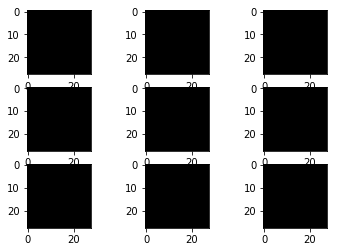

In [213]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')